#Sign Language Detection


##Abstract
This project focuses on developing a deep learning model to accurately predict and classify hand gestures, representing words, and numbers in American Sign Language. With a primary aim to facilitate communication with deaf children, especially those born to hearing parents unfamiliar with ASL, the project leverages a comprehensive dataset comprising hand landmarks extracted from video frames. Utilizing advanced image processing techniques and machine learning algorithms, the model interprets hand positions, movements, and finger configurations to translate sign language into text. The goal of this project is to learn more aboout CV and deep learning techneques in the context of ASL while creating a an effective solution for people who use ASL.

##Introduction
Background
Communication barriers between deaf individuals and those unfamiliar with sign language pose significant challenges. Particularly, deaf children born to hearing parents often face communication gaps, as many parents do not initially know sign language. This project aims to bridge this gap by leveraging technology to translate American Sign Language into text, thus aiding parents, educators, and caregivers in learning and interacting more effectively with deaf children.

Objectives
The primary objective of this project is to develop a deep learning-based model capable of accurately detecting and classifying ASL signs. The model will interpret hand gestures, including the position, movement, and orientation of hands and fingers, to translate these into corresponding textual representations.

Dataset and Methods
The dataset for this project is sourced from a Kaggle competition, comprising landmark data extracted from videos using the MediaPipe holistic model. This data includes normalized spatial coordinates for hand landmarks, which are the critical features for model training. The project will employ various image processing techniques, such as edge detection and finger positioning analysis, alongside deep learning models like Convolutional Neural Networks (CNNs) and Recurrent Neural Networks (RNNs), to interpret these signs. The model’s performance will be evaluated using accuracy, precision, recall, and F1-score metrics, and the final model will be converted into TensorFlow Lite format for practical deployment.

**Step 1:** Setup Environment and Dependencies

In [ ]:
!pip install tensorflow numpy pandas matplotlib scikit-learn opencv-python

In [11]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import cv2
import os
from sklearn.model_selection import train_test_split


**Step 2:** Data Acquisition and Loading

In [3]:
from google.colab import files
files.upload()  # This will allow us to upload the kaggle.json file


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yoha00","key":"009129d68ea830c0102186e43b0dd39f"}'}

In [4]:
# setting up kaggle environment
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [5]:
# now we use the kaggle API to download the asl dataset
!kaggle competitions download -c asl-signs

100% 37.4G/37.4G [21:21<00:00, 39.4MB/s]
100% 37.4G/37.4G [21:21<00:00, 31.3MB/s]


In [ ]:
# Unzip the downloaded file
!unzip asl-signs.zip

In [22]:
#looking at the file structure
!ls


asl-signs.zip  sample_data			  train.csv
kaggle.json    sign_to_prediction_index_map.json  train_landmark_files


In [16]:
# Taking a look at the train.csv
df = pd.read_csv('/content/train.csv')
df.head()

,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie


###Evaluation

Based on the structure above it looks like we have a number of participents in the data set who have each taken part in signing a word. Denoted by their participant ID.

We can also see that there are multiple signes in the data set that are denoted by their sign ID each corriponding to a participant_id and a parquet file for the landmark data.

In [17]:
# Taking a look at the sign_to_prediction_index_map.json file
df = pd.read_csv('/content/sign_to_prediction_index_map.json')
df.head()

,"{""TV"": 0","""after"": 1","""airplane"": 2","""all"": 3","""alligator"": 4","""animal"": 5","""another"": 6","""any"": 7","""apple"": 8","""arm"": 9",...,"""why"": 240","""will"": 241","""wolf"": 242","""yellow"": 243","""yes"": 244","""yesterday"": 245","""yourself"": 246","""yucky"": 247","""zebra"": 248","""zipper"": 249}"


In [18]:
#After unzipping we have a folder named train_landmark_files in our current directory with the following files
!ls '/content/train_landmark_files'

16069  2044   25571  27610  29302  32319  36257  37779	49445  55372  62590
18796  22343  26734  28656  30680  34503  37055  4718	53618  61333


In [19]:
#Example of file count in one of our folders
!ls -l '/content/train_landmark_files/16069' | wc -l
!ls -l '/content/train_landmark_files/18796' | wc -l

4849
3503


In [20]:
#Based in vusila inspcetion it seems like all of the folders have the same data type a Parquet file
#Let's look at one of the files
!file "/content/train_landmark_files/16069/100015657.parquet"


/content/train_landmark_files/16069/100015657.parquet: Apache Parquet


#Exploratory Data Analysis



For the Exploratory Data Analysis, we'll focus on understanding the train.csv file's contents and characteristics.


> Basic Descriptive Statistics: This includes counts, means, and other statistical measures that give a quick overview of the data.


> Missing Values Check: To ensure the integrity of the dataset, we will check for any missing values.


> Visualization of Sign Distribution: A visual representation (such as a histogram or bar chart) to show the distribution of different signs in the dataset.



Additionally, we'll analyze:

> The number of unique signs in the dataset.


> The number of unique participants.


> The distribution of the number of .parquet files (landmark files) per sign, focusing on the top 20 signs with the most files


In [21]:
# Lets start by creating our data frame

# Load the train.csv file into a DataFrame
train_csv_path = '/content/train.csv'
train_df = pd.read_csv(train_csv_path)

In [22]:
#Show basic Descriptive Statistics
basic_stats = train_df.describe(include='all')
basic_stats

,path,participant_id,sequence_id,sign
count,94477,94477.000000,9.447700e+04,94477
unique,94477,NaN,NaN,250
top,train_landmark_files/26734/1000035562.parquet,NaN,NaN,listen
freq,1,NaN,NaN,415
mean,NaN,33678.632366,2.149377e+09,NaN
std,NaN,16138.124387,1.239239e+09,NaN
min,NaN,2044.000000,8.528200e+04,NaN
25%,NaN,25571.000000,1.078076e+09,NaN
50%,NaN,32319.000000,2.154240e+09,NaN
75%,NaN,49445.000000,3.218820e+09,NaN


In [23]:
# Number of Unique Signs in the data set
unique_signs_count = train_df['sign'].nunique()
unique_signs_count

250

In [24]:
#  Next we calculate the number of unique participants in the dataset.
unique_participants_count = train_df['participant_id'].nunique()
unique_participants_count

21

In [25]:
# To understand which signs have the most data points, we look at the distribution of .parquet files per sign.
parquets_per_sign = train_df['sign'].value_counts().head(20)
parquets_per_sign

listen        415
look          414
shhh          411
donkey        410
mouse         408
duck          405
hear          405
uncle         405
pretend       404
bird          404
cow           404
sleepy        403
brown         403
who           403
bye           402
nuts          402
fireman       402
lips          402
toothbrush    402
wake          401
Name: sign, dtype: int64

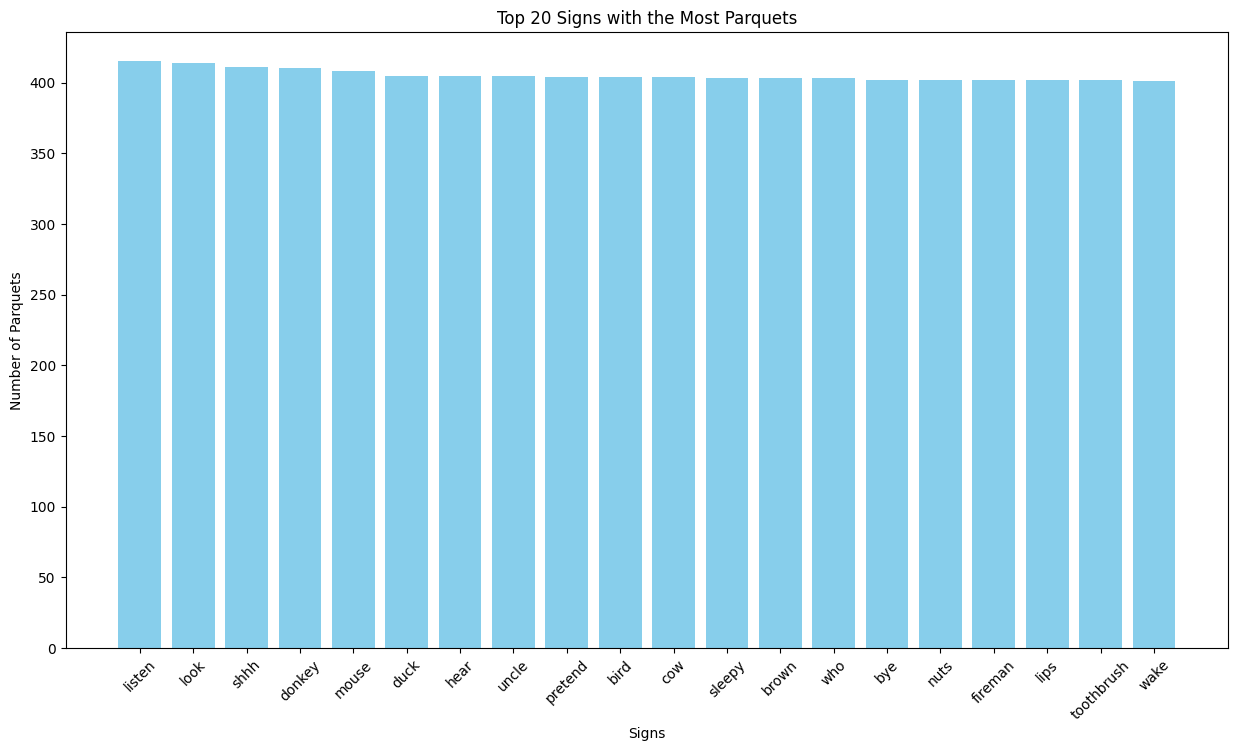

In [26]:
# To better visualize this we plot the distribution the top 20 signs

# Preparing data for visualization
top_signs = parquets_per_sign.index.tolist()
top_signs_counts = parquets_per_sign.values.tolist()

# Visualization code
plt.figure(figsize=(15, 8))
plt.bar(top_signs, top_signs_counts, color='skyblue')
plt.xlabel('Signs')
plt.ylabel('Number of Parquets')
plt.title('Top 20 Signs with the Most Parquets')
plt.xticks(rotation=45)
plt.show()


In [27]:
# Final lets check for missing values
missing_values = train_df.isnull().sum()
missing_values

path              0
participant_id    0
sequence_id       0
sign              0
dtype: int64

##### **TODO** add more analysis for EDA in relation to parquet files

##Data pre-processing

next step is data pre-processing. This phase involves preparing the .parquet files in the train_landmark_files folder, which contain the landmark data for the sign language gestures, for model training.

In [30]:
# Reading the .praquet files

# Example of reading a single .parquet file
file_path = 'train_landmark_files/16069/100015657.parquet'  # Replace with actual file path
parquet_data = pd.read_parquet(file_path)
parquet_data.head()
parquet_data.shape

(57015, 7)

In [ ]:
# Now lets read all of the .parquet files in the train_landmark_files folder
# We'll save the processed files in a log file incase we need to restart the process
# We'll use the log file to skip files that have already been processed
# We'll save prgress of our process in a batch file every 2000 files

import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import datetime

def read_log(log_path):
    if os.path.exists(log_path):
        with open(log_path, 'r') as file:
            processed_files = file.read().splitlines()
        return set(processed_files)
    else:
        return set()

def update_log(log_path, file_name):
    with open(log_path, 'a') as file:
        file.write(file_name + '\n')

root_folder = '/content/train_landmark_files'
scaler = MinMaxScaler()
batch_size = 2000
log_path = 'processed_files_log.txt'
processed_files = read_log(log_path)

for subfolder in os.listdir(root_folder):
    subfolder_path = os.path.join(root_folder, subfolder)
    if os.path.isdir(subfolder_path):
        all_data = pd.DataFrame()
        file_count = 0

        for file in os.listdir(subfolder_path):
            if file in processed_files:
                continue  # Skip if the file is already processed

            file_path = os.path.join(subfolder_path, file)
            parquet_data = pd.read_parquet(file_path)
            data_of_interest = parquet_data[parquet_data['type'].isin(['left_hand', 'right_hand', 'pose'])].copy()
            data_of_interest[['x', 'y', 'z']] = scaler.fit_transform(data_of_interest[['x', 'y', 'z']])
            sequence_id = int(file.split('.')[0])
            data_of_interest['sequence_id'] = sequence_id
            all_data = pd.concat([all_data, data_of_interest], ignore_index=True)

            update_log(log_path, file)  # Update the log
            file_count += 1
            if file_count >= batch_size:
                break

        batch_filename = f'batch_{len(processed_files)//batch_size}.csv'
        all_data.to_csv(batch_filename, index=False)
        print(f"Batch {len(processed_files)//batch_size} saved. Timestamp: {datetime.datetime.now()}")


In [7]:
# prompt: how check csv file

import pandas as pd

# Read the CSV file
df = pd.read_csv('/content/batch_0 (2).csv')

# Check the shape of the DataFrame
print('\n check the shape of the DataFrame:')
print(df.shape)

# Check the column names
print( '\n check the column names:')
print(df.columns)

# Check the data types of each column
print('\n check the data types of each column:')
print(df.dtypes)

# Check the missing values
print('\n check the missing values:')
print(df.isnull().sum())

# Check the unique values in each column
print('\n check the unique values in each column:')
for column in df.columns:
    print(df[column].unique())

# Check the distribution of each column
print('\n check the distribution of each column:')
for column in df.columns:
    print(df[column].value_counts())



 check the shape of the DataFrame:
(6854100, 8)

 check the column names:
Index(['frame', 'row_id', 'type', 'landmark_index', 'x', 'y', 'z',
       'sequence_id'],
      dtype='object')

 check the data types of each column:
frame               int64
row_id             object
type               object
landmark_index      int64
x                 float64
y                 float64
z                 float64
sequence_id         int64
dtype: object

 check the missing values:
frame                   0
row_id                  0
type                    0
landmark_index          0
x                 2611371
y                 2611371
z                 2611371
sequence_id             0
dtype: int64

 check the unique values in each column:
[ 28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45
  46   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  


Data Shape and Columns:

The DataFrame has 6,854,100 rows and 8 columns. This is a large dataset, so efficient processing and memory management will be crucial.


Data Types: Most columns are of expected types (integers and floats). Ensure these types align with the intended use in the model.

Missing Values: Columns 'x', 'y', and 'z' have 2,611,371 missing values each. We'll handel these missing values by replacing them with 0's.

Unique Values and Distribution: The distribution of values in columns like 'frame', 'row_id', 'type', and 'landmark_index' indicates a wide range of data points.
The 'type' column suggests data from three categories: 'left_hand', 'right_hand', and 'pose'.

The distribution of 'sequence_id' shows how many data points are available per sequence.

### Feature Engineering

1.   **Landmark Aggregation**: For each frame and each type (left hand, right hand, pose), we would like to create a feature vector that aggregateates the landmark data. This means creating a single feature vector per frame per type that encapsulates all the landmarks.

2.   **Temporal Features**: Since this is time-series data (sequential data across frames), we'll be creating features that capture the temporal aspect, like the change in position of landmarks from one frame to the next.

Then we will reshape the data into a format that can be fed into the model.

**Reshaping Data**: We reshape the data into a suitable format. For sequence models like LSTM or GRU (common in handling time-series data), we need to structure the data into sequences.


In [8]:
# Pull lables from train.csv

# Read the train.csv file
train_df = pd.read_csv('/content/train.csv')

# Create a dictionary mapping from sequence_id to sign label
sign_labels = dict(zip(train_df['sequence_id'], train_df['sign']))


In [43]:
# Sample data for demonstration (replace with your actual DataFrame)
import pandas as pd
import numpy as np

sequence_length = 20


def create_temporal_features(df):
    # Calculating differences in coordinates for each landmark
    df[['x_diff', 'y_diff', 'z_diff']] = df.groupby(['sequence_id', 'type', 'landmark_index'])[['x', 'y', 'z']].diff().fillna(0)
    temporal_features = []
    for (sequence_id, frame, typ), group in df.groupby(['sequence_id', 'frame', 'type']):
        sorted_group = group.sort_values(by='landmark_index')
        differences = sorted_group[['x_diff', 'y_diff', 'z_diff']].values.flatten()
        temporal_features.append((sequence_id, frame, typ, differences))
    return pd.DataFrame(temporal_features, columns=['sequence_id', 'frame', 'type', 'Features'])
temporal_data = create_temporal_features(df)

# Function to validate features
# This code will check if the feature vectors for a given frame and sequence_id in our dataset align with the expected structure.
def validate_features(temporal_data, sequence_id, frame, expected_features):
    frame_data = temporal_data[(temporal_data['sequence_id'] == sequence_id) & (temporal_data['frame'] == frame)]
    for _, row in frame_data.iterrows():
        features = row['Features']
        if len(features) != expected_features[row['type']]:
            return False, f"Mismatch in features for type {row['type']} at frame {frame} of sequence {sequence_id}"
    return True, "All features are correctly structured"

# Feature lengths for each type
expected_feature_lengths = {
    'left_hand': 63,  # 21 landmarks * 3 coordinates
    'right_hand': 63,
    'pose': 99  # 33 landmarks * 3 coordinates
}

# Validate for a particular frame and sequence_id
validation_result = validate_features(temporal_data, sequence_id=1, frame=0, expected_features=expected_feature_lengths)
print(validation_result)


(True, 'All features are correctly structured')


In [95]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

sequence_length = 20

def structure_data_for_lstm(temporal_data, sequence_length, sign_labels):
    sequences = []
    labels = []

    for sequence_id in temporal_data['sequence_id'].unique():
        sequence_data = temporal_data[temporal_data['sequence_id'] == sequence_id]
        label = sign_labels.get(sequence_id)
        if label is None:
            continue

        feature_vectors = []
        for frame in range(sequence_data['frame'].max() + 1):
            frame_data = sequence_data[sequence_data['frame'] == frame]
            feature_vector = np.zeros(225)  # Initialize with zeros
            # [Your code to create feature_vector for each type]
            for typ in ['left_hand', 'right_hand', 'pose']:
                type_data = frame_data[frame_data['type'] == typ]['Features']
                if not type_data.empty:
                    type_features = type_data.iloc[0]  # Assumes each type only has one row per frame
                    # Check if type_features has the expected number of elements
                    expected_length = 63 if typ in ['left_hand', 'right_hand'] else 99  # 99 for pose
                    if len(type_features) == expected_length:
                        start_index = 0 if typ == 'left_hand' else (63 if typ == 'right_hand' else 126)
                        feature_vector[start_index:start_index + expected_length] = type_features
                    else:
                        # Handle the case where type_features is not as long as expected
                        print(f"Warning: Missing data for {typ} in sequence {sequence_id}, frame {frame}")

            feature_vectors.append(feature_vector)

        # Padding the sequence
        feature_vectors_padded = pad_sequences([feature_vectors], maxlen=sequence_length, padding='post', dtype='float32')[0]

        sequences.append(feature_vectors_padded)
        labels.append(label)

    return np.array(sequences), np.array(labels)

sequences, labels = structure_data_for_lstm(temporal_data, sequence_length, sign_labels)


## Model Building

### Number of Features
we  have 21  unique landmarks for each hand and 33 landmarks for the pose.
For each landmark, we have x, y, z coordinates.
Thus, for each type (left hand, right hand, pose), you have 21 * 3 = 63 features for hands and 33 * 3 = 99 features for pose.
If you're using all these features, n_features would be 63 (left hand) + 63 (right hand) + 99 (pose) = 225.

In [97]:
# we use TensorFlow and Keras to define the LSTM model.
# The model architecture can be simple to start with, and then we can expand or modify it based on the model's performance.

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# We are using 225 features and we are classifying into 'n_classes' categories
n_features = 225
n_classes = len(np.unique(labels))  # Calculate the number of unique labels

# Define the sequence length (number of frames per sequence)


# Define the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(sequence_length, n_features)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(n_classes, activation='softmax')  # Use 'softmax' for multi-class classification
])

# Output the number of classes and model summary
print(f"Number of classes: {n_classes}")
model.summary()


Number of classes: 250
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 20, 50)            55200     
                                                                 
 dropout_16 (Dropout)        (None, 20, 50)            0         
                                                                 
 lstm_17 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_17 (Dropout)        (None, 50)                0         
                                                                 
 dense_10 (Dense)            (None, 250)               12750     
                                                                 
Total params: 88150 (344.34 KB)
Trainable params: 88150 (344.34 KB)
Non-trainable params: 0 (0.00 Byte)
___________________________________________________________

In [90]:
# Compile the Model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [140]:
# Data Preparation for Training


# Split the data into training and validation sets.
# The split is 80% for training and 20% for validation.
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(sequences, labels, test_size=0.2, random_state=64)

# Check the shapes and types of the training and validation data
print(X_train.shape, X_train.dtype)
print(y_train.shape, y_train.dtype)
print(X_val.shape, X_val.dtype)
print(y_val.shape, y_val.dtype)


(1600, 20, 225) float32
(1600,) <U12
(400, 20, 225) float32
(400,) <U12


We can see from the data that the labels are encoded as integers but the features are strings. We need to convert them to integers.

In [141]:
from sklearn.preprocessing import LabelEncoder

# Create the label encoder
label_encoder = LabelEncoder()

# Fit the encoder to your labels (all labels in dataset)
label_encoder.fit(np.concatenate((y_train, y_val), axis=0))

# Transform the training and validation labels
y_train_encoded = label_encoder.transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# Check the shapes and types again
print(y_train_encoded.shape, y_train_encoded.dtype)
print(y_val_encoded.shape, y_val_encoded.dtype)


(1600,) int64
(400,) int64


In [93]:
# Model Training
history = model.fit(
    X_train, y_train_encoded,  # Use integer-encoded labels for training
    validation_data=(X_val, y_val_encoded),  # Use integer-encoded labels for validation
    epochs=10,
    batch_size=32
)



Epoch 1/10
50/50 [==============================] - 4s 24ms/step - loss: 5.5225 - accuracy: 0.0031 - val_loss: 5.5216 - val_accuracy: 0.0125
Epoch 2/10
50/50 [==============================] - 0s 8ms/step - loss: 5.5165 - accuracy: 0.0088 - val_loss: 5.5251 - val_accuracy: 0.0025
Epoch 3/10
50/50 [==============================] - 0s 8ms/step - loss: 5.5025 - accuracy: 0.0056 - val_loss: 5.5253 - val_accuracy: 0.0000e+00
Epoch 4/10
50/50 [==============================] - 0s 8ms/step - loss: 5.4840 - accuracy: 0.0075 - val_loss: 5.5361 - val_accuracy: 0.0125
Epoch 5/10
50/50 [==============================] - 0s 8ms/step - loss: 5.4560 - accuracy: 0.0075 - val_loss: 5.5195 - val_accuracy: 0.0075
Epoch 6/10
50/50 [==============================] - 0s 8ms/step - loss: 5.4141 - accuracy: 0.0081 - val_loss: 5.5085 - val_accuracy: 0.0200
Epoch 7/10
50/50 [==============================] - 0s 8ms/step - loss: 5.3680 - accuracy: 0.0119 - val_loss: 5.4855 - val_accuracy: 0.0150
Epoch 8/10
50/5

Changing model architecture to Bidirectional LSTM to see if that improves performance

In [150]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l1_l2


n_features = 225
n_classes = len(np.unique(labels))

regularizer = l1_l2(l1=0.01, l2=0.01)  # Example regularization parameters, these may need tuning


model = Sequential([
    Bidirectional(LSTM(200, return_sequences=True, input_shape=(sequence_length, n_features))),
    Dropout(0.7),
    Bidirectional(LSTM(200)),
    Dropout(0.7),
    Dense(100, activation='relu', kernel_regularizer=regularizer),
    Dense(n_classes, activation='softmax')
])

# Using a custom learning rate
#optimizer = Adam(learning_rate=0.0001)

#model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

optimizer = RMSprop(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
sample_input = np.random.random((1, sequence_length, n_features))
model(sample_input)

model.summary()


Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_30 (Bidirect  (1, 20, 400)              681600    
 ional)                                                          
                                                                 
 dropout_45 (Dropout)        (1, 20, 400)              0         
                                                                 
 bidirectional_31 (Bidirect  (1, 400)                  961600    
 ional)                                                          
                                                                 
 dropout_46 (Dropout)        (1, 400)                  0         
                                                                 
 dense_37 (Dense)            (1, 100)                  40100     
                                                                 
 dense_38 (Dense)            (1, 250)                

In [153]:
model = Sequential([
    LSTM(100, input_shape=(sequence_length, n_features)),
    Dropout(0.5),
    Dense(n_classes, activation='softmax')
])

# Using a custom learning rate
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#model(sample_input)

model.summary()


Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_42 (LSTM)              (None, 100)               130400    
                                                                 
 dropout_47 (Dropout)        (None, 100)               0         
                                                                 
 dense_39 (Dense)            (None, 250)               25250     
                                                                 
Total params: 155650 (608.01 KB)
Trainable params: 155650 (608.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [154]:
#Data preprocessing
from sklearn.preprocessing import StandardScaler

# Assuming 'sequences' is your data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val_scaled = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)


In [157]:
#training procedure
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)


history = model.fit(
    X_train_scaled, y_train_encoded,
    validation_data=(X_val_scaled, y_val_encoded),
    epochs=50,  # Increased epochs
    batch_size=16,  # Adjusted batch size
    callbacks=[early_stopping]
)


Epoch 1/50
100/100 [==============================] - 1s 6ms/step - loss: 0.2296 - accuracy: 0.9737 - val_loss: 6.5063 - val_accuracy: 0.0375
Epoch 2/50
100/100 [==============================] - 1s 6ms/step - loss: 0.1969 - accuracy: 0.9837 - val_loss: 6.5250 - val_accuracy: 0.0375
Epoch 3/50
100/100 [==============================] - 1s 5ms/step - loss: 0.2051 - accuracy: 0.9725 - val_loss: 6.6032 - val_accuracy: 0.0500
Epoch 4/50
100/100 [==============================] - 1s 5ms/step - loss: 0.2072 - accuracy: 0.9669 - val_loss: 6.5575 - val_accuracy: 0.0400


**Based on the above, we can see that the training accuracy is increasing over epochs, the validation accuracy is decreasing over epochs, and the validation loss is increasing over epochs which can be interprated as the following:**

**Increasing Training Accuracy:** The model's training accuracy is increasing over epochs, which is a positive sign. It suggests that the model is learning from the training data.

**Validation Accuracy Not Keeping Pace:** However, the validation accuracy is much lower and doesn't increase at the same rate. This could be a sign of overfitting, where the model learns the training data too well, including its noise and outliers, but does not generalize well to new, unseen data.

**Rising Validation Loss:** The increasing validation loss further supports the possibility of overfitting.

To address these issues, we will consider adding the following steps:

**Regularization**: Implement dropout layers or L2 regularization to prevent overfitting.
Data Augmentation: If possible, augment your data to introduce more variability and help the model generalize better.

**Early Stopping**: Implement early stopping to terminate training when the validation loss starts to increase, preventing overfitting.

**Hyperparameter Tuning:** Optimize Model Architecture and Tune LSTM Units Adjust the number of units in LSTM layers. Sometimes fewer units can help the model generalize better.

**Layer Adjustments:** Experiment with adding or removing layers to find a better architecture balance

In [146]:
# accounting for class imbalance

from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)
class_weight_dict = dict(enumerate(class_weights))

history = model.fit(
    X_train_scaled, y_train_encoded,
    validation_data=(X_val_scaled, y_val_encoded),
    epochs=50,
    batch_size=8,
    class_weight=class_weight_dict,
    callbacks=[early_stopping]
)


Epoch 1/50
200/200 [==============================] - 7s 18ms/step - loss: 3.9584 - accuracy: 0.1863 - val_loss: 5.3828 - val_accuracy: 0.0525
Epoch 2/50
200/200 [==============================] - 2s 11ms/step - loss: 3.3910 - accuracy: 0.2262 - val_loss: 5.5687 - val_accuracy: 0.0450
Epoch 3/50
200/200 [==============================] - 2s 11ms/step - loss: 2.6470 - accuracy: 0.3675 - val_loss: 5.7771 - val_accuracy: 0.0525
Epoch 4/50
200/200 [==============================] - 2s 12ms/step - loss: 1.9898 - accuracy: 0.4919 - val_loss: 6.5177 - val_accuracy: 0.0700


more changes to see if it improves performance

In [107]:
from sklearn.preprocessing import MinMaxScaler

# Assuming 'X_train' and 'X_val' are your training and validation sets
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val_scaled = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)


In [111]:
from tensorflow.keras.layers import GRU

model = Sequential([
    Bidirectional(GRU(100, return_sequences=True, input_shape=(sequence_length, n_features))),
    Dropout(0.3),
    Bidirectional(GRU(100)),
    Dropout(0.3),
    Dense(100, activation='relu'),
    Dense(n_classes, activation='softmax')
])

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
sample_input = np.random.random((1, sequence_length, n_features))
model(sample_input)

model.summary()


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_12 (Bidirect  (1, 20, 200)              196200    
 ional)                                                          
                                                                 
 dropout_26 (Dropout)        (1, 20, 200)              0         
                                                                 
 bidirectional_13 (Bidirect  (1, 200)                  181200    
 ional)                                                          
                                                                 
 dropout_27 (Dropout)        (1, 200)                  0         
                                                                 
 dense_18 (Dense)            (1, 100)                  20100     
                                                                 
 dense_19 (Dense)            (1, 250)                

In [112]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Add 'checkpoint' to the callbacks list in model.fit
history = model.fit(
    X_train_scaled, y_train_encoded,
    validation_data=(X_val_scaled, y_val_encoded),
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping, checkpoint]  # Add 'checkpoint' here
)


Epoch 1/50
25/25 [==============================] - 8s 72ms/step - loss: 5.5545 - accuracy: 0.0031 - val_loss: 5.5231 - val_accuracy: 0.0050
Epoch 2/50
11/25 [============>.................] - ETA: 0s - loss: 5.5209 - accuracy: 0.0043

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 0s 13ms/step - loss: 5.5398 - accuracy: 0.0031 - val_loss: 5.5309 - val_accuracy: 0.0000e+00
Epoch 3/50
25/25 [==============================] - 0s 13ms/step - loss: 5.5237 - accuracy: 0.0044 - val_loss: 5.5427 - val_accuracy: 0.0025
Epoch 4/50
25/25 [==============================] - 0s 14ms/step - loss: 5.5232 - accuracy: 0.0044 - val_loss: 5.5409 - val_accuracy: 0.0050
Epoch 5/50
25/25 [==============================] - 0s 13ms/step - loss: 5.5200 - accuracy: 0.0056 - val_loss: 5.5386 - val_accuracy: 0.0050
Epoch 6/50
25/25 [==============================] - 0s 14ms/step - loss: 5.5133 - accuracy: 0.0044 - val_loss: 5.5446 - val_accuracy: 0.0000e+00
Epoch 7/50
25/25 [==============================] - 0s 13ms/step - loss: 5.5175 - accuracy: 0.0044 - val_loss: 5.5502 - val_accuracy: 0.0025
Epoch 8/50
25/25 [==============================] - 0s 14ms/step - loss: 5.5062 - accuracy: 0.0056 - val_loss: 5.5680 - val_accuracy: 0.0000e+00
Epoch 9/50
2

At this point we can see that the mdoel is overfitting. If we had more time we would see if we could improve the model by applying more regularization, data augmentation, and hyperparameter tuning.

At this point we're going to try another more complex archetecture to see if that improves performance. In the next phase we'll expore transformer models with the same dataset.